# Quantile-quantile (QQ) scaled climate projections

In [1]:
import glob
import calendar

import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
import dask.diagnostics
import cmdline_provenance as cmdprov
from dask.distributed import Client, LocalCluster

from calc_adjustment import read_data
from apply_adjustment import check_units

In [2]:
#dask.diagnostics.ProgressBar().register()

In [3]:
cluster = LocalCluster()
client = Client(cluster)

2022-05-12 16:47:19,613 - distributed.diskutils - INFO - Found stale lock file and directory '/home/599/dbi599/qqscale/dask-worker-space/worker-iul6tkte', purging
2022-05-12 16:47:19,631 - distributed.diskutils - INFO - Found stale lock file and directory '/home/599/dbi599/qqscale/dask-worker-space/worker-8idnccqp', purging
2022-05-12 16:47:19,667 - distributed.diskutils - INFO - Found stale lock file and directory '/home/599/dbi599/qqscale/dask-worker-space/worker-4679b8qo', purging
2022-05-12 16:47:19,692 - distributed.diskutils - INFO - Found stale lock file and directory '/home/599/dbi599/qqscale/dask-worker-space/worker-ngj28_tn', purging


In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35659,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:36975,Total threads: 4
Dashboard: http://127.0.0.1:34701/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:33193,


In [5]:
# Parameters
variable = 'tasmax'
obs_name = 'AGCD'
model_name = 'ACCESS1-3'
future_scenario = 'rcp45'
model_run = 'r1i1p1'

historical_time_bounds = ['1986-01-01', '2005-12-31']
future_time_bounds = ['2021-01-01', '2040-12-31']

spatial_selection = None
spatial_aggregation = "none"

example_point = [-42.9, 147.3]
example_month = 6

output_units = 'C'
model_units = None

mapping_method = 'additive'

output_file = '/g/data/wp00/dbi599/tasmax_day_AGCD-ACCESS1-3_rcp45_r1i1p1_20210101-20401231.nc'

In [6]:
agcd_var_names = {'tasmax': 'tmax'}
agcd_units = {'tasmax': 'C'}
if obs_name == 'AGCD':
    obs_var = agcd_var_names[variable]
    obs_units = agcd_units[variable]
else:
    obs_var = variable
    obs_units = None

model_var = variable

In [7]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'obs_name' in locals(), "Must provide the name of an observational dataset"
assert 'variable' in locals(), "Must provide a variable name"

## Read data

In [8]:
hist_files = ['/g/data/rr3/publications/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/day/atmos/day/r1i1p1/latest/tasmax/tasmax_day_ACCESS1-3_historical_r1i1p1_19750101-19991231.nc',
              '/g/data/rr3/publications/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/day/atmos/day/r1i1p1/latest/tasmax/tasmax_day_ACCESS1-3_historical_r1i1p1_20000101-20051231.nc']

In [9]:
ds_hist = read_data(
    hist_files,
    model_var,
    time_bounds=historical_time_bounds,
    spatial_sel=spatial_selection,
    spatial_agg=spatial_aggregation,
    input_units=model_units,
    output_units=output_units)
ds_hist[model_var]

<xarray.DataArray 'tasmax' (time: 7305, lat: 145, lon: 192)>
dask.array<truediv, shape=(7305, 145, 192), dtype=float32, chunksize=(7305, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1986-01-01T12:00:00 ... 2005-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Maximum Near-Surface Air Temperature
    units:             °C
    cell_methods:      time: maximum
    cell_measures:     area: areacella
    history:           2012-04-03T11:23:29Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [10]:
ds_hist = ds_hist.compute()

In [11]:
future_files = ['/g/data/rr3/publications/CMIP5/output1/CSIRO-BOM/ACCESS1-3/rcp45/day/atmos/day/r1i1p1/latest/tasmax/tasmax_day_ACCESS1-3_rcp45_r1i1p1_20060101-20301231.nc',
                '/g/data/rr3/publications/CMIP5/output1/CSIRO-BOM/ACCESS1-3/rcp45/day/atmos/day/r1i1p1/latest/tasmax/tasmax_day_ACCESS1-3_rcp45_r1i1p1_20310101-20551231.nc']

In [12]:
ds_future = read_data(
    future_files,
    model_var,
    time_bounds=future_time_bounds,
    spatial_sel=spatial_selection,
    spatial_agg=spatial_aggregation,
    input_units=model_units,
    output_units=output_units)
ds_future[model_var]

<xarray.DataArray 'tasmax' (time: 7305, lat: 145, lon: 192)>
dask.array<truediv, shape=(7305, 145, 192), dtype=float32, chunksize=(7305, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01T12:00:00 ... 2040-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Maximum Near-Surface Air Temperature
    units:             °C
    cell_methods:      time: maximum
    cell_measures:     area: areacella
    history:           2012-04-03T07:15:04Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [13]:
ds_future = ds_future.compute()

In [14]:
obs_files = glob.glob('/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_*.nc')
obs_files.sort()

In [15]:
obs_files

['/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1910.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1911.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1912.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1913.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1914.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1915.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1916.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1917.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1918.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1919.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1920.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1921.nc',
 '/g/data/zv2/ag

In [16]:
ds_obs = read_data(
    obs_files,
    obs_var,
    time_bounds=historical_time_bounds,
    spatial_sel=spatial_selection,
    spatial_agg=spatial_aggregation,
    input_units=obs_units,
    output_units=output_units
)

In [17]:
ds_obs[obs_var] = ds_obs[obs_var].chunk({'lat': 10, 'lon': 10})

In [18]:
ds_obs[obs_var]

,Array,Chunk
Bytes,16.66 GiB,2.79 MiB
Shape,"(7305, 691, 886)","(7305, 10, 10)"
Count,12814 Tasks,6230 Chunks
Type,float32,numpy.ndarray


In [19]:
lat_min_obs = ds_obs['lat'].values.min()
lat_max_obs = ds_obs['lat'].values.max()
lon_min_obs = ds_obs['lon'].values.min()
lon_max_obs = ds_obs['lon'].values.max()

In [20]:
print(lat_min_obs, lat_max_obs, lon_min_obs, lon_max_obs)

-44.5 -10.0 112.0 156.25


In [21]:
#da_obs = da_obs.compute()

## Quantile mapping

In [22]:
mapping_methods = {'additive': '+', 'multiplicative': '*'}
qq_mapping = sdba.EmpiricalQuantileMapping.train(
    ds_future[model_var],
    ds_hist[model_var],
    nquantiles=100,
    group="time.month",
    kind=mapping_methods[mapping_method]
)
if 'lat' in qq_mapping.ds.dims:
    qq_mapping.ds = qq_mapping.ds.assign_coords({'lat': ds_future['lat'], 'lon': ds_future['lon']}) #xclim strips lat/lon attributes
    qq_mapping.ds = qq_mapping.ds.transpose('quantiles', 'month', 'lat', 'lon')
qq_mapping.ds['quantiles'] = qq_mapping.ds['quantiles'] * 100

In [23]:
qq_mapping.ds['hist_q']

<xarray.DataArray 'hist_q' (quantiles: 100, month: 12, lat: 145, lon: 192)>
array([[[[-38.428303  , -38.428303  , -38.428303  , ..., -38.43791   ,
          -38.43791   , -38.43791   ],
         [-36.13462   , -36.175594  , -36.21674   , ..., -36.038162  ,
          -36.047894  , -36.081913  ],
         [-34.474724  , -34.58518   , -34.686855  , ..., -34.1397    ,
          -34.24661   , -34.354946  ],
         ...,
         [-44.312366  , -44.458073  , -44.319454  , ..., -44.505104  ,
          -44.490253  , -44.52079   ],
         [-44.656048  , -44.619354  , -44.58426   , ..., -44.740673  ,
          -44.74135   , -44.70418   ],
         [-45.678635  , -45.678635  , -45.678635  , ..., -45.678635  ,
          -45.678635  , -45.678635  ]],

        [[-52.620335  , -52.620335  , -52.620335  , ..., -52.630325  ,
          -52.630325  , -52.630325  ],
         [-49.923244  , -49.900505  , -49.90401   , ..., -49.968742  ,
          -49.957073  , -49.940044  ],
         [-48.606358  , -48.696457  , -48.774315  , ..., -48.137913  ,
          -48.411777  , -48.488678  ],
...
         [ -1.1593618 ,  -1.1834512 ,  -1.2558604 , ...,  -1.9967953 ,
           -1.7421654 ,  -1.3741004 ],
         [ -1.669021  ,  -1.6024957 ,  -1.4854436 , ...,  -1.9236939 ,
           -1.8536013 ,  -1.7492938 ],
         [ -4.4266367 ,  -4.4266367 ,  -4.4266367 , ...,  -4.4266367 ,
           -4.4266367 ,  -4.4266367 ]],

        [[-15.657446  , -15.657446  , -15.657446  , ..., -15.664917  ,
          -15.664917  , -15.664917  ],
         [-13.767874  , -13.851628  , -13.939852  , ..., -13.538868  ,
          -13.6094675 , -13.6868305 ],
         [-13.593059  , -13.680081  , -13.750788  , ..., -13.200896  ,
          -13.335243  , -13.458674  ],
         ...,
         [ -2.09315   ,  -2.0187578 ,  -1.9444193 , ...,  -2.9840226 ,
           -2.4430454 ,  -2.1707497 ],
         [ -2.2684085 ,  -2.227102  ,  -2.2209551 , ...,  -2.3242927 ,
           -2.3222916 ,  -2.2949572 ],
         [ -3.8773735 ,  -3.8773735 ,  -3.8773735 , ...,  -3.8773735 ,
           -3.8773735 ,  -3.8773735 ]]]], dtype=float32)
Coordinates:
  * quantiles  (quantiles) float32 0.5 1.5 2.5 3.5 4.5 ... 96.5 97.5 98.5 99.5
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:     Model quantiles
    long_name:         Quantiles of model on the reference period
    units:             °C
    cell_methods:      time: maximum
    cell_measures:     area: areacella
    history:           2012-04-03T11:23:29Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [24]:
def quantile_month_plot(da, cmap=None, point=None):
    """Create two dimensional month/quantile plot"""

    fig, ax = plt.subplots(figsize=[16, 6])
    if 'lat' in da.dims:
        example_lat, example_lon = example_point
        quantiles = da.sel({'lat': example_lat, 'lon': example_lon}, method='nearest')
    else:
        quantiles = da
    quantiles.transpose('month', 'quantiles').plot(cmap=cmap)
    yticks = np.arange(1,13)
    ytick_labels = [calendar.month_abbr[i] for i in yticks]
    plt.yticks(yticks, ytick_labels)
    ax.invert_yaxis()
    plt.show()

In [25]:
def quantile_spatial_plot(
    da, month, lat_bounds=None, lon_bounds=None, example_point=None, cmap=None
):
    """Spatial plot of the 10th, 50th and 90th percentile"""
    
    da_selection = da.sel({'quantiles': [10, 50, 90], 'month': month}, method='nearest')
    if lat_bounds:
        lat_min_obs, lat_max_obs = lat_bounds
        da_selection = da_selection.sel(lat=slice(lat_min_obs, lat_max_obs))
    if lon_bounds:
        lon_min_obs, lon_max_obs = lon_bounds
        da_selection = da_selection.sel(lon=slice(lon_min_obs, lon_max_obs))   
    p = da_selection.plot(
        col='quantiles',
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        figsize=[20, 5.5],
        subplot_kws={'projection': ccrs.PlateCarree()}
    )
    for ax in p.axes.flat:
        ax.coastlines()
        if example_point:
            lat, lon = example_point
            ax.plot(lon, lat, 'go', zorder=5, transform=ccrs.PlateCarree())
    plt.suptitle(calendar.month_name[month])
    plt.show()

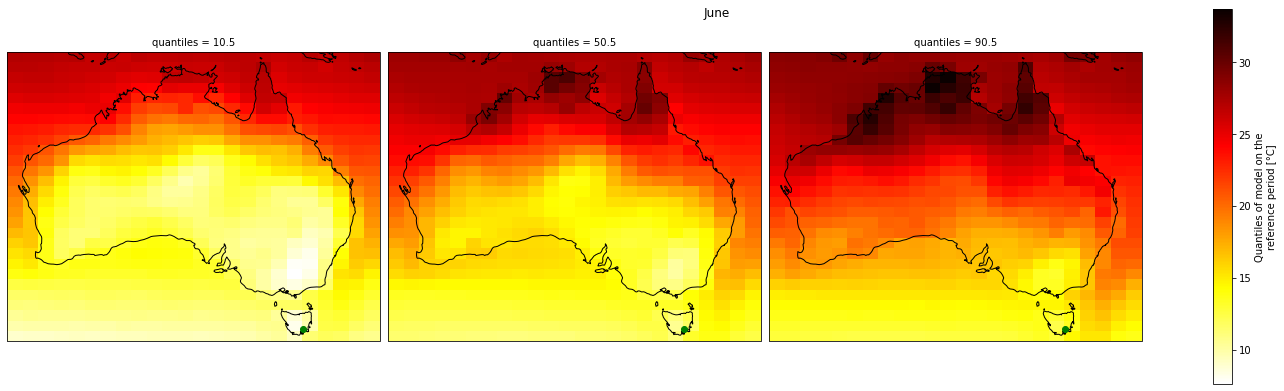

In [26]:
if 'lat' in qq_mapping.ds.dims:
    quantile_spatial_plot(
        qq_mapping.ds['hist_q'],
        example_month,
        lat_bounds=[lat_min_obs, lat_max_obs],
        lon_bounds=[lon_min_obs, lon_max_obs],
        example_point=example_point,
        cmap='hot_r',
    )

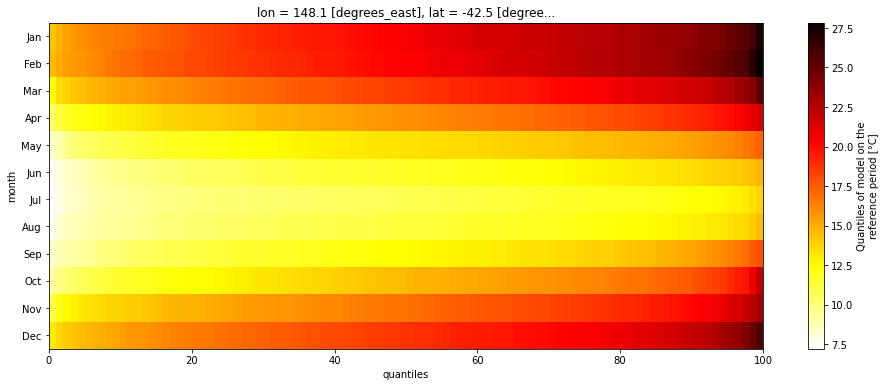

In [27]:
quantile_month_plot(qq_mapping.ds['hist_q'], cmap='hot_r', point=example_point)

In [28]:
qq_mapping.ds['af']

<xarray.DataArray 'af' (quantiles: 100, month: 12, lat: 145, lon: 192)>
array([[[[ 1.02273941e+00,  1.02273941e+00,  1.02273941e+00, ...,
           1.01774597e+00,  1.01774597e+00,  1.01774597e+00],
         [ 2.91271210e-01,  3.25668335e-01,  3.54988098e-01, ...,
           2.15332031e-01,  2.14885712e-01,  2.43598938e-01],
         [ 1.59034729e-02,  5.94673157e-02,  1.10832214e-01, ...,
           9.21974182e-02,  1.02077484e-01,  7.86476135e-02],
         ...,
         [ 3.57881546e+00,  3.64996338e+00,  3.48257446e+00, ...,
           3.75357819e+00,  3.81137085e+00,  3.85863495e+00],
         [ 3.12276077e+00,  3.08337402e+00,  3.03149033e+00, ...,
           3.27622604e+00,  3.26162338e+00,  3.18132401e+00],
         [ 3.52148056e+00,  3.52148056e+00,  3.52148056e+00, ...,
           3.52148056e+00,  3.52148056e+00,  3.52148056e+00]],

        [[ 3.08032990e-01,  3.08032990e-01,  3.08032990e-01, ...,
           3.04237366e-01,  3.04237366e-01,  3.04237366e-01],
         [ 1.16242218e+00,  1.09769058e+00,  1.00433350e+00, ...,
           1.21752930e+00,  1.20428848e+00,  1.17882156e+00],
         [ 4.10804749e-01,  4.11174774e-01,  3.69426727e-01, ...,
           5.90244293e-01,  5.47275543e-01,  3.90445709e-01],
...
           1.24329650e+00,  1.08392274e+00,  7.97353685e-01],
         [ 1.37530804e-01,  1.15993857e-01,  3.23691368e-02, ...,
           2.50352740e-01,  2.16516018e-01,  1.76259279e-01],
         [ 1.71843719e+00,  1.71843719e+00,  1.71843719e+00, ...,
           1.71843719e+00,  1.71843719e+00,  1.71843719e+00]],

        [[ 9.29088593e-01,  9.29088593e-01,  9.29088593e-01, ...,
           9.20155525e-01,  9.20155525e-01,  9.20155525e-01],
         [ 3.15273285e-01,  3.33244324e-01,  3.98035049e-01, ...,
           1.69036865e-01,  2.30743408e-01,  2.51716614e-01],
         [ 1.22991467e+00,  1.46189785e+00,  1.77363491e+00, ...,
           9.43224907e-01,  9.68945503e-01,  1.05793190e+00],
         ...,
         [-1.83271384e+00, -1.76495385e+00, -1.87339652e+00, ...,
          -1.12208366e+00, -1.59968209e+00, -1.80385613e+00],
         [-1.77716422e+00, -1.82331300e+00, -1.69771147e+00, ...,
          -1.84146643e+00, -1.81107688e+00, -1.76994848e+00],
         [-7.99239397e-01, -7.99239397e-01, -7.99239397e-01, ...,
          -7.99239397e-01, -7.99239397e-01, -7.99239397e-01]]]],
      dtype=float32)
Coordinates:
  * quantiles  (quantiles) float32 0.5 1.5 2.5 3.5 4.5 ... 96.5 97.5 98.5 99.5
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:     Adjustment factors
    long_name:         Quantile mapping adjustment factors
    units:             °C
    cell_methods:      time: maximum
    cell_measures:     area: areacella
    history:           2012-04-03T07:15:04Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...
    kind:              +

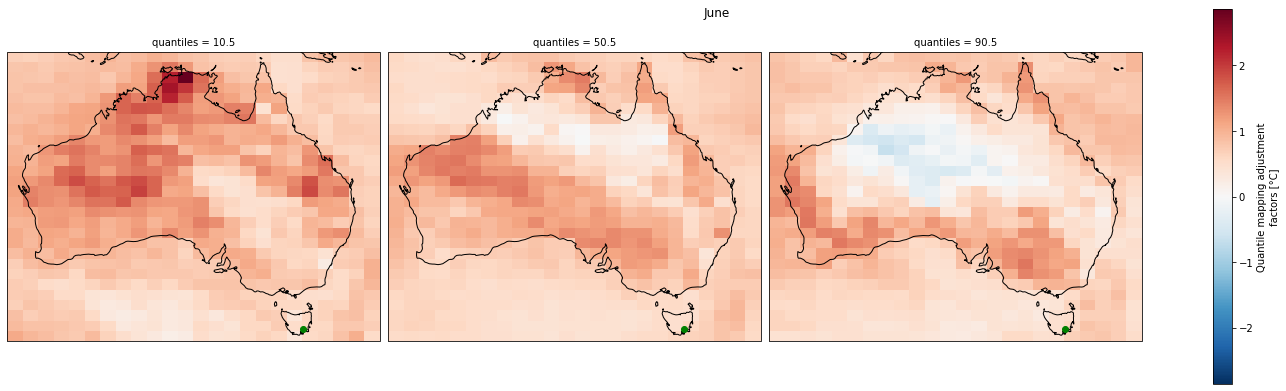

In [29]:
if 'lat' in qq_mapping.ds.dims:
    quantile_spatial_plot(
        qq_mapping.ds['af'],
        example_month,
        lat_bounds=[lat_min_obs, lat_max_obs],
        lon_bounds=[lon_min_obs, lon_max_obs],
        example_point=example_point,
    )

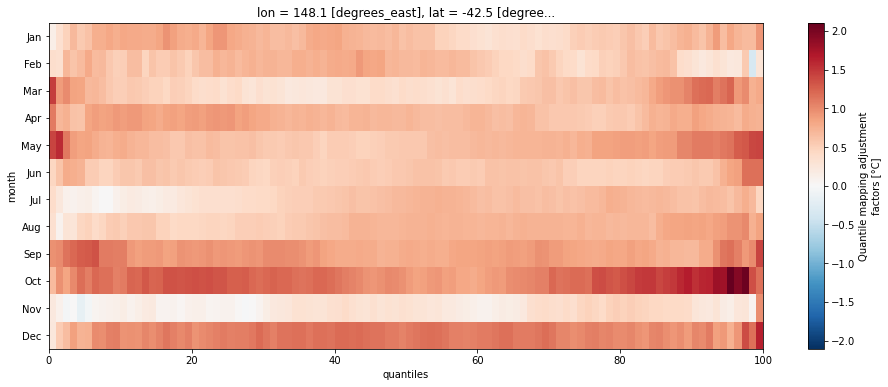

In [30]:
quantile_month_plot(qq_mapping.ds['af'], point=example_point)

## QQ-scaled projections

In [31]:
if 'lat' in qq_mapping.ds.dims:
    regridder = xe.Regridder(ds_hist, ds_obs, "bilinear")
    qq_mapping.ds = regridder(qq_mapping.ds)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [35]:
qq_mapping.ds['hist_q'].attrs['units'] = ds_hist[model_var].attrs['units']
qq_mapping.ds['af'].attrs['units'] = ds_hist[model_var].attrs['units']
ds_obs[obs_var], qq_mapping = check_units(ds_obs[obs_var], qq_mapping, obs_units, model_units, output_units)

In [36]:
qq_mapping.ds = qq_mapping.ds.compute()

In [37]:
qq_obs = qq_mapping.adjust(ds_obs[obs_var], extrapolation="constant", interp="linear")
qq_obs = qq_obs.rename(variable)
if 'lat' in qq_obs.dims:
    qq_obs = qq_obs.transpose('time', 'lat', 'lon')
time_adjustment = ds_future['time'].values[0] - qq_obs['time'].values[0]
qq_obs = qq_obs.assign_coords({'time': qq_obs['time'].values + time_adjustment})

qq_obs

,Array,Chunk
Bytes,16.66 GiB,2.79 MiB
Shape,"(7305, 691, 886)","(7305, 10, 10)"
Count,81344 Tasks,6230 Chunks
Type,float32,numpy.ndarray


In [ ]:
#q_obs = qq_obs.compute()

In [ ]:
qq_obs.attrs['history'] = cmdprov.new_log()
qq_obs.to_netcdf(output_file)

In [ ]:
#fig, ax = plt.subplots(figsize=[20, 8])
#da_hist.plot(label="historical")
#da_future.plot(label=future_scenario)
#da_obs.plot(label=obs_name, linestyle=':', alpha=0.8)
#qq_obs.plot(label="QQ data", linestyle=':', alpha=0.8)
#plt.title(variable)
#plt.legend()
#plt.show()

In [ ]:
#fig, ax = plt.subplots(figsize=[14, 7])
#da_hist.groupby("time.dayofyear").mean().plot(label="historical")
#da_future.groupby("time.dayofyear").mean().plot(label=future_scenario)
#da_obs.groupby("time.dayofyear").mean().plot(label=obs_name)
#qq_obs.groupby("time.dayofyear").mean().plot(label="QQ-scaled data")
#plt.legend()
#plt.title('Daily climatology')
#plt.show()

In [ ]:
#fig = plt.figure(figsize=[10, 6])
#da_obs.plot.hist(bins=50, density=True, label=obs_name, alpha=0.7)
#qq_obs.plot.hist(bins=50, density=True, label='QQ-scaled data', facecolor='green', alpha=0.7)
#plt.ylabel('probability')
#plt.title(f'{variable} distribution')
#plt.legend()
#plt.show()